In [1]:
!pip install kaggle

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"ahmedakram1","key":"55e8f2815d9380d549a31b1e2c714508"}'}

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle competitions download -c jigsaw-toxic-comment-classification-challenge -p /content/

  0% 0.00/52.6M [00:00<?, ?B/s]
100% 52.6M/52.6M [00:00<00:00, 668MB/s]


In [5]:
!unzip /content/jigsaw-toxic-comment-classification-challenge.zip -d /content/data/

Archive:  /content/jigsaw-toxic-comment-classification-challenge.zip
  inflating: /content/data/sample_submission.csv.zip  
  inflating: /content/data/test.csv.zip  
  inflating: /content/data/test_labels.csv.zip  
  inflating: /content/data/train.csv.zip  


In [6]:
!unzip /content/data/train.csv.zip -d /content/data/
!unzip /content/data/test.csv.zip -d /content/data/
!unzip /content/data/sample_submission.csv.zip -d /content/data/

Archive:  /content/data/train.csv.zip
  inflating: /content/data/train.csv  
Archive:  /content/data/test.csv.zip
  inflating: /content/data/test.csv  
Archive:  /content/data/sample_submission.csv.zip
  inflating: /content/data/sample_submission.csv  


In [10]:
import pandas as pd, numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [9]:
train = pd.read_csv('/content/data/train.csv')
test = pd.read_csv('/content/data/test.csv')
subm = pd.read_csv('/content/data/sample_submission.csv')

In [11]:
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [12]:
train['comment_text'][0]

"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27"

In [14]:
train['comment_text'][2]

"Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about the formatting than the actual info."

In [13]:
lens = train.comment_text.str.len()
lens.mean(), lens.std(), lens.max()

(np.float64(394.0732213246768), 590.7202819048923, 5000)

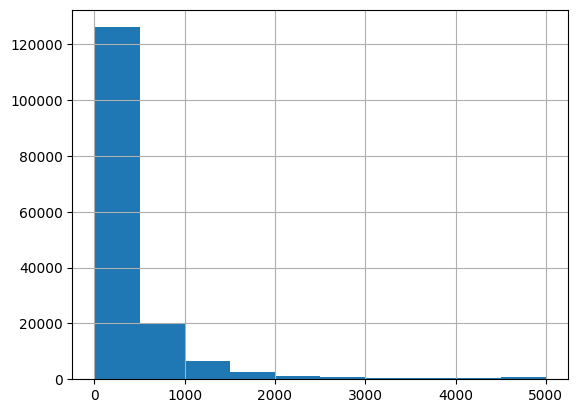

In [17]:
lens.hist();

In [18]:
label_cols = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
train['none'] = 1-train[label_cols].max(axis=1)
train.describe()

,toxic,severe_toxic,obscene,threat,insult,identity_hate,none
count,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000
mean,0.095844,0.009996,0.052948,0.002996,0.049364,0.008805,0.898321
std,0.294379,0.099477,0.223931,0.054650,0.216627,0.093420,0.302226
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [19]:
len(train),len(test)

(159571, 153164)

In [20]:
COMMENT = 'comment_text'
train[COMMENT].fillna("unknown", inplace=True)
test[COMMENT].fillna("unknown", inplace=True)

/tmp/ipython-input-214498403.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  test[COMMENT].fillna("unknown", inplace=True)


In [21]:
import re, string
re_tok = re.compile(f'([{string.punctuation}“”¨«»®´·º½¾¿¡§£₤‘’])')
def tokenize(s): return re_tok.sub(r' \1 ', s).split()

In [23]:
n = train.shape[0]
vec = TfidfVectorizer(ngram_range=(1,2), tokenizer=tokenize,
               min_df=3, max_df=0.9, strip_accents='unicode', use_idf=True,
               smooth_idf=True, sublinear_tf=True )
trn_term_doc = vec.fit_transform(train[COMMENT])
test_term_doc = vec.transform(test[COMMENT])

/usr/local/lib/python3.12/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [24]:
trn_term_doc, test_term_doc

(<Compressed Sparse Row sparse matrix of dtype 'float64'
 	with 17775119 stored elements and shape (159571, 426005)>,
 <Compressed Sparse Row sparse matrix of dtype 'float64'
 	with 14765768 stored elements and shape (153164, 426005)>)

In [25]:
def pr(y_i, y):
    p = x[y==y_i].sum(0)
    return (p+1) / ((y==y_i).sum()+1)

In [26]:
x = trn_term_doc
test_x = test_term_doc

In [31]:
from sklearn.linear_model import LogisticRegression

def get_mdl(y):
    m = LogisticRegression(solver='lbfgs', dual=False, max_iter=1000)
    m.fit(trn_term_doc, y)
    r = 1.0
    return m, r


In [32]:
preds = np.zeros((len(test), len(label_cols)))

for i, j in enumerate(label_cols):
    print('fit', j)
    m,r = get_mdl(train[j])
    preds[:,i] = m.predict_proba(test_x.multiply(r))[:,1]

fit toxic
fit severe_toxic
fit obscene
fit threat
fit insult
fit identity_hate


In [33]:
submid = pd.DataFrame({'id': subm["id"]})
submission = pd.concat([submid, pd.DataFrame(preds, columns = label_cols)], axis=1)
submission.to_csv('submission.csv', index=False)